## Import

In [1]:
from os import walk 
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud

from PIL import Image

from sklearn.model_selection import train_test_split


c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Constants

In [2]:
Example_file="SpamData/01_Processing/practice_email.txt"
Spam_1_Path="SpamData/01_Processing/spam_assassin_corpus/spam_1"
Spam_2_Path="SpamData/01_Processing/spam_assassin_corpus/spam_2"
Easy_NonSpam_1_Path="SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
Easy_NonSpam_2_Path="SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

Spam_Cat=1
Ham_Cat=0
Vocab_size=2500


DATA_JSON_FILE ='SpamData/01_Processing/email-text-data.json'
Word_Id_FILE ='SpamData/01_Processing/word-by-id.csv'

Training_Data_File='SpamData/02_Training/train-data.txt'
Test_Data_File='SpamData/02_Training/test-data.txt'

Whale_file='SpamData/01_Processing/wordcloud_resources/whale-icon.png'
Skull_file='SpamData/01_Processing/wordcloud_resources/skull-icon.png'
Thumbs_up_file='SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
Thumbs_down_file='SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

Custom_font_file='SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

 ## Reading File

In [3]:
stream=open(Example_file,encoding='latin-1')
message=stream.read()
stream.close()
print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream=open(Example_file,encoding='latin-1')
lines=[]
is_body=False
for line in stream:
    if is_body:
        lines.append(line)
    elif line=='\n':
        is_body=True
stream.close()

email_body='\n'.join(lines)
print(email_body)
# print(lines)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generator Function

In [6]:
def generate_squares(n):
    for i in range(n):
        yield i**2

In [7]:
generate_squares(4)

<generator object generate_squares at 0x00000182237D1900>

In [8]:
for i in generate_squares(4):
    print(i,end="-->")

0-->1-->4-->9-->

## Email Body Extraction

In [9]:
def email_body_generator(path):
   for root,dirnames,filenames in walk(path):
      for file_name in filenames:
            filepath=join(root,file_name)
            stream=open(filepath,encoding='latin-1')
            lines=[]
            is_body=False
            for line in stream:
               if is_body:
                  lines.append(line)
               elif line=='\n':
                  is_body=True
            stream.close()

            email_body='\n'.join(lines)
            yield file_name,email_body

In [10]:
def df_from_directory(path,classification):
    rows=[]
    row_names=[]
    for file_name,email_body in email_body_generator(path):
        rows.append({'Message':email_body,"Category":classification})
        row_names.append(file_name)

    return pd.DataFrame(rows,index=row_names)

In [11]:
spam_emails=df_from_directory(Spam_1_Path,Spam_Cat)
spam_emails=pd.concat([df_from_directory(Spam_2_Path,Spam_Cat),spam_emails])
spam_emails.head()
spam_emails.shape

(1898, 2)

In [12]:
ham_emails=df_from_directory(Easy_NonSpam_1_Path,Ham_Cat)
ham_emails=pd.concat([df_from_directory(Easy_NonSpam_2_Path,Ham_Cat),ham_emails])
ham_emails.shape

(3901, 2)

In [13]:
data=pd.concat([spam_emails,ham_emails])
print('shape of entire dataframe is : ',data.shape)
data.tail()


shape of entire dataframe is :  (5799, 2)


,Message,Category
02497.60497db0a06c2132ec2374b2898084d3,"Hi Gianni,\n\n\n\nA very good resource for thi...",0
02498.09835f512f156da210efb99fcc523e21,Gianni Ponzi wrote:\n\n> I have a prob when tr...,0
02499.b4af165650f138b10f9941f6cc5bce3c,Neale Pickett <neale@woozle.org> writes:\n\n\n...,0
02500.05b3496ce7bca306bed0805425ec8621,"\n\nHi,\n\n\n\nI think you need to give us a l...",0
cmds,,0


## Data Cleaning : Checking for Missing Values

In [14]:
# Check if any message bodies are null
data['Message'].isnull().values.any()

False

In [15]:
# Check if there is empty email (string length = 0)
(data.Message.str.len()==0).any()

True

In [16]:
(data.Message.str.len()==0).sum()

3

In [17]:
data['Message'].isnull().sum()

0

### Locate Empty Emails

In [18]:
type(data.Message.str.len()==0)

pandas.core.series.Series

In [19]:
data[data.Message.str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [20]:
# data.index.get_loc()

## Remove System File Entries from Dataframe

In [21]:
data.drop(["cmds"],inplace=True)    

In [22]:
data.shape

(5796, 2)

## Add Document Ids to Track Emails in Dataset

In [23]:
document_ids=range(0,len(data.index))
data['Doc_Id']=document_ids


In [24]:
data.Doc_Id

00001.317e78fa8ee2f54cd4890fdc09ba8176       0
00002.9438920e9a55591b18e60d1ed37d992b       1
00003.590eff932f8704d8b0fcbe69d023b54d       2
00004.bdcc075fa4beb5157b5dd6cd41d8887b       3
00005.ed0aba4d386c5e62bc737cf3f0ed9589       4
                                          ... 
02496.aae0c81581895acfe65323f344340856    5791
02497.60497db0a06c2132ec2374b2898084d3    5792
02498.09835f512f156da210efb99fcc523e21    5793
02499.b4af165650f138b10f9941f6cc5bce3c    5794
02500.05b3496ce7bca306bed0805425ec8621    5795
Name: Doc_Id, Length: 5796, dtype: int64

In [25]:
data['File_Name']=data.index
data.set_index('Doc_Id',inplace=True)
data.head()

,Message,Category,File_Name
Doc_Id,,,
0,Greetings!\n\n\n\nYou are receiving this lette...,1,00001.317e78fa8ee2f54cd4890fdc09ba8176
1,<html>\n\n<body>\n\n<center>\n\n<h3>\n\n<font ...,1,00002.9438920e9a55591b18e60d1ed37d992b
2,<html>\n\n<body>\n\n<center>\n\n<b>\n\n<font c...,1,00003.590eff932f8704d8b0fcbe69d023b54d
3,<html>\n\n<body>\n\n<center>\n\n<b>\n\n<font c...,1,00004.bdcc075fa4beb5157b5dd6cd41d8887b
4,"<html><xbody>\n\n<hr width = ""100%"">\n\n<cente...",1,00005.ed0aba4d386c5e62bc737cf3f0ed9589


## Save to File Using Pandas

In [26]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Messages Visualised(Pie Charts)

In [27]:
data.Category.value_counts()

0    3900
1    1896
Name: Category, dtype: int64

In [28]:
amount_of_spam=data.Category.value_counts()[1]
amount_of_ham=data.Category.value_counts()[0]

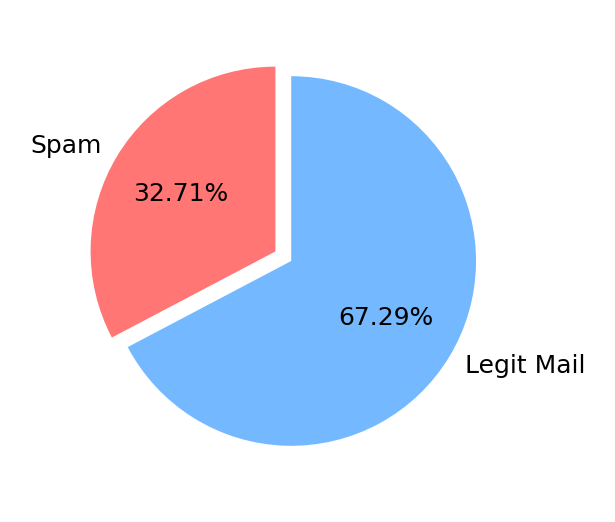

In [29]:
category_name=['Spam','Legit Mail']
sizes=[amount_of_spam,amount_of_ham]
custom_colors=['#ff7675','#74b9ff']

plt.figure(figsize=(2,2),dpi=300)
plt.pie(sizes,labels=category_name,textprops={'fontsize':6},startangle=90,autopct='%1.2f%%',
        colors=custom_colors,explode=[0.1,0])
plt.show()

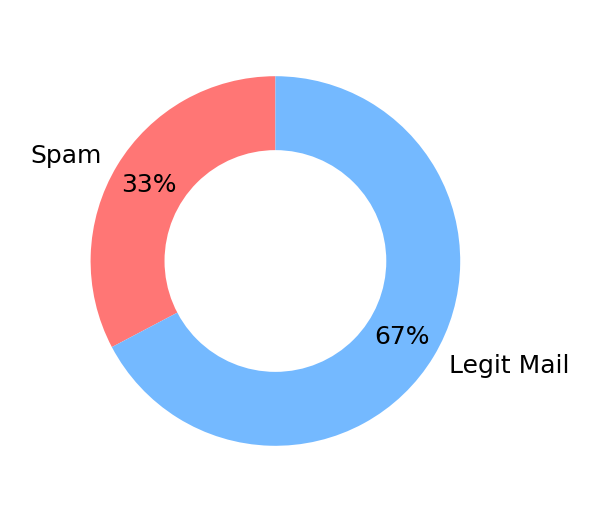

In [30]:
category_name=['Spam','Legit Mail']
sizes=[amount_of_spam,amount_of_ham]
custom_colors=['#ff7675','#74b9ff']

plt.figure(figsize=(2,2),dpi=300)
plt.pie(sizes,labels=category_name,textprops={'fontsize':6},startangle=90,autopct='%1.0f%%',
        colors=custom_colors,pctdistance=0.8)
#Draw Cicle
center_circle=plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(center_circle)
plt.show()

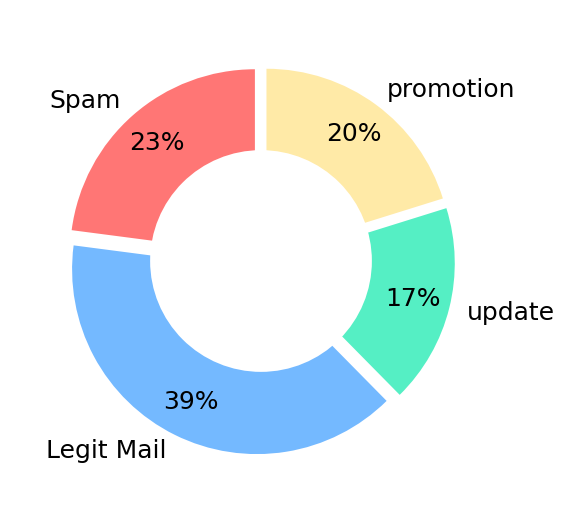

In [31]:
category_name=['Spam','Legit Mail','update','promotion']
sizes=[25,43,19,22]
custom_colors=['#ff7675','#74b9ff','#55efc4','#ffeaa7']
offset=[0.05,0.05,0.05,0.05]

plt.figure(figsize=(2,2),dpi=300)
plt.pie(sizes,labels=category_name,textprops={'fontsize':6},startangle=90,autopct='%1.0f%%',
        colors=custom_colors,pctdistance=0.8,explode=offset)
#Draw Cicle
center_circle=plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(center_circle)
plt.show()

## Natural Language Processing

### Text Pre-processing

### Download the nltk resources ( Tokenizer & Stopwords)

In [32]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenising

In [35]:
msg='All Work and no play makes a Person Dull.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'a', 'person', 'dull', '.']

### Remove Stop Words

In [36]:
stop_words=set(stopwords.words('english'))

In [37]:
msg='All Work and no play makes a Person Dull. To be not to be.'
words=word_tokenize(msg.lower())
filtered_words=[]

for i in words:
    if i not in stop_words:
        filtered_words.append(i)
filtered_words

['work', 'play', 'makes', 'person', 'dull', '.', '.']

## Word Stems and Stemming

In [38]:
msg='All Work and no play makes a Person Dull. To be not to be.\
    Nobody excepts the spanish inquisition!'
words=word_tokenize(msg.lower())
# stemmer=PorterStemmer()
stemmer=SnowballStemmer('english')
filtered_words=[]

for word in words:
    if word not in stop_words:
        stemmed_word=stemmer.stem(word)
        filtered_words.append(stemmed_word)
filtered_words

['work',
 'play',
 'make',
 'person',
 'dull',
 '.',
 '.',
 'nobodi',
 'except',
 'spanish',
 'inquisit',
 '!']

## Removing Punctuation

In [39]:
msg='All Work and no play makes a Person Dull. To be not to be.\
    Nobody excepts the spanish inquisition!'
words=word_tokenize(msg.lower())
# stemmer=PorterStemmer()
stemmer=SnowballStemmer('english')
filtered_words=[]

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word=stemmer.stem(word)
        filtered_words.append(stemmed_word)
filtered_words

['work',
 'play',
 'make',
 'person',
 'dull',
 'nobodi',
 'except',
 'spanish',
 'inquisit']

## Removing HTML tags from Emails

In [40]:
soup=BeautifulSoup(data.at[2,'Message'],'html.parser')
# print(soup.prettify())

In [41]:
print(soup.get_text())







*****Bonus Fat Absorbers As Seen On TV, Included Free With Purchase Of 2 Or More Bottle, $24.95 Value*****





***TAKE $10.00 OFF 2 & 3 MONTH SUPPLY ORDERS, $5.00 OFF 1 MONTH SUPPLY!

***AND STILL GET YOUR BONUS!  PRICE WILL BE DEDUCTED DURING PROCESSING.




***FAT ABSORBERS ARE GREAT FOR THOSE WHO WANT TO LOSE WEIGHT,  BUT CAN'T STAY ON A DIET***




***OFFER GOOD UNTIL MAY 27, 2002!  FOREIGN ORDERS INCLUDED!







LOSE 30 POUNDS  IN 30 DAYS... GUARANTEED!!!






All Natural Weight-Loss Program, Speeds Up The Metabolism Safely

Rated #1 In Both Categories of SAFETY & EFFECTIVENESS In

(THE United States Today)



WE'LL HELP YOU GET THINNER!

WE'RE GOING TO HELP YOU LOOK GOOD, FEEL GOOD AND TAKE CONTROL IN

2002









Why Use Our Amazing Weight Loss Capsules?



*  They act like a natural magnet to attract fat.

*  Stimulates the body's natural metabolism. 

*  Controls appetite naturally and makes it easier to

   eat the right foods consistently.

*  Reduces craving for 

## Function for Email Processing

In [42]:
def clean_message(message,stemmer=PorterStemmer(),stop_words=set(stopwords.words('english'))):
    # Remove HTML tags
    soup=BeautifulSoup(message,'html.parser')
    clean_text=soup.get_text()
    # convert to lower case and split up words 
    words= word_tokenize(clean_text.lower())

    filtered_words=[]

    for word in words:
        # Remove the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))

    return filtered_words

In [43]:
clean_message(data.at[2,'Message'])

['bonu',
 'fat',
 'absorb',
 'seen',
 'tv',
 'includ',
 'free',
 'purchas',
 'bottl',
 'valu',
 'take',
 'month',
 'suppli',
 'order',
 'month',
 'suppli',
 'still',
 'get',
 'bonu',
 'price',
 'deduct',
 'process',
 'fat',
 'absorb',
 'great',
 'want',
 'lose',
 'weight',
 'ca',
 'stay',
 'diet',
 'offer',
 'good',
 'may',
 'foreign',
 'order',
 'includ',
 'lose',
 'pound',
 'day',
 'guarante',
 'natur',
 'program',
 'speed',
 'metabol',
 'safe',
 'rate',
 'categori',
 'safeti',
 'effect',
 'unit',
 'state',
 'today',
 'help',
 'get',
 'thinner',
 'go',
 'help',
 'look',
 'good',
 'feel',
 'good',
 'take',
 'control',
 'use',
 'amaz',
 'weight',
 'loss',
 'capsul',
 'act',
 'like',
 'natur',
 'magnet',
 'attract',
 'fat',
 'stimul',
 'bodi',
 'natur',
 'metabol',
 'control',
 'appetit',
 'natur',
 'make',
 'easier',
 'eat',
 'right',
 'food',
 'consist',
 'reduc',
 'crave',
 'sweet',
 'aid',
 'absorpt',
 'fat',
 'overal',
 'digest',
 'inhibit',
 'bad',
 'cholesterol',
 'boost',
 'good

### Apply Cleaning and Tokenisation to all messages

#### Slicing Dataframe and Series & Creating Subsets 

In [44]:
print(data.iat[2,2])

00003.590eff932f8704d8b0fcbe69d023b54d


In [45]:
first_emails = data.Message.iloc[0:3]
nested_list  = first_emails.apply(clean_message)

In [46]:
# flat_list=[]
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)
flat_list=[item for sublist in nested_list for item in sublist]
len(flat_list)

914

In [47]:

nested_list=data.Message.apply(clean_message)

c:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [48]:
nested_list.tail()

Doc_Id
5791    [man, kill, surf, tube, train, ananova, wednes...
5792    [hi, gianni, good, resourc, http, http, walk, ...
5793    [gianni, ponzi, wrote, prob, tri, instal, linu...
5794    [neal, pickett, write, skip, montanaro, write,...
5795    [hi, think, need, give, us, littl, detail, inf...
Name: Message, dtype: object

## Using Logic to Slice Dataframes

In [49]:
doc_ids_spam=data[data.Category==1].index
doc_ids_ham=data[data.Category==0].index

### Subsetting a Series with an Index

In [50]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [51]:
type(nested_list)

pandas.core.series.Series

In [52]:
nested_list_ham=nested_list.loc[doc_ids_ham]
nested_list_ham.head()

Doc_Id
1896    [date, tue, aug, chri, garrigu, hope, peopl, a...
1897    [date, wed, aug, tue, aug, edt, said, ever, tr...
1898    [robert, elz, date, wed, aug, date, tue, aug, ...
1899    [ouch, get, right, robert, elz, date, wed, aug...
1900    [wed, aug, robert, elz, said, hmm, use, mh, lo...
Name: Message, dtype: object

In [53]:
nested_list_spam=nested_list.loc[doc_ids_spam]

In [54]:
flat_list_ham=[item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()
normal_words.shape[0]
# normal_words 


20814

In [55]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [56]:
flat_list_spam=[item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()
spammy_words.shape[0]

13241

In [57]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

## Creating a word cloud

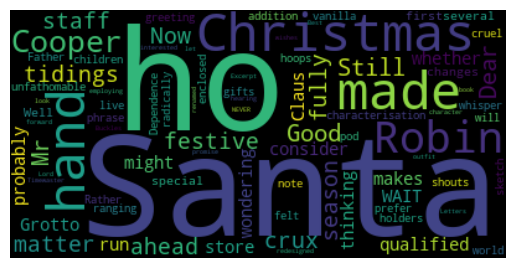

In [58]:
word_cloud=WordCloud().generate(email_body)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [59]:
example_corpus=nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [60]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [61]:
word_list=[''.join(word) for word in example_corpus]
novel_as_string=' '.join(word_list)


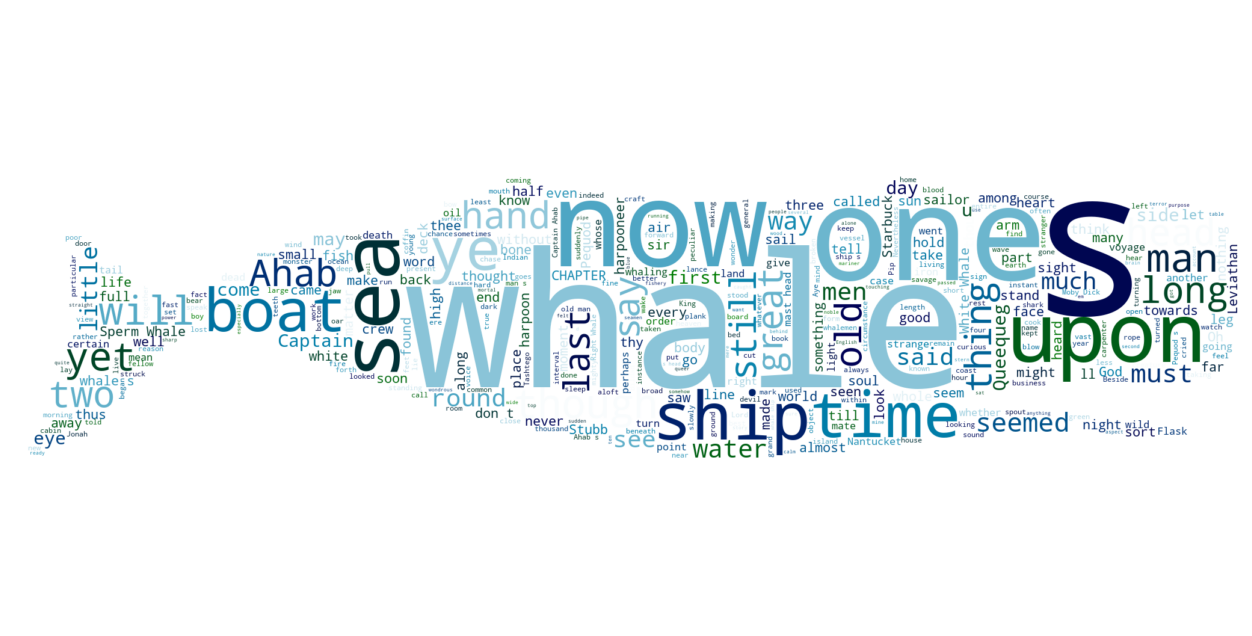

In [62]:
icon=Image.open(Whale_file)
  
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array=np.array(image_mask)# converts image object to array
word_cloud=WordCloud(mask=rgb_array,background_color='white',
                     max_words=400,colormap='ocean')
word_cloud.generate(novel_as_string)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [63]:
rgb_array.shape

(1024, 2048, 3)

In [64]:
rgb_array[1023,2047] # it will be white and not used for word cloud

array([255, 255, 255], dtype=uint8)

In [65]:
rgb_array[500,1000] # it will be black and used for word cloud

array([0, 0, 0], dtype=uint8)

## Word Cloud for Spam and Ham Messages

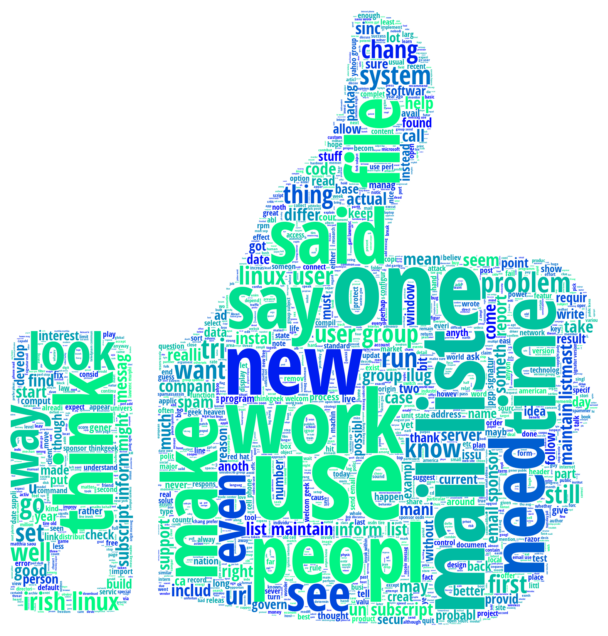

In [66]:
icon=Image.open(Thumbs_up_file)  
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array=np.array(image_mask)# converts image object to array

ham_str=' '.join(flat_list_ham)
word_cloud=WordCloud(mask=rgb_array,background_color='white',
                     max_words=2000,colormap='winter',font_path=Custom_font_file,
                     max_font_size=300)
word_cloud.generate(ham_str)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

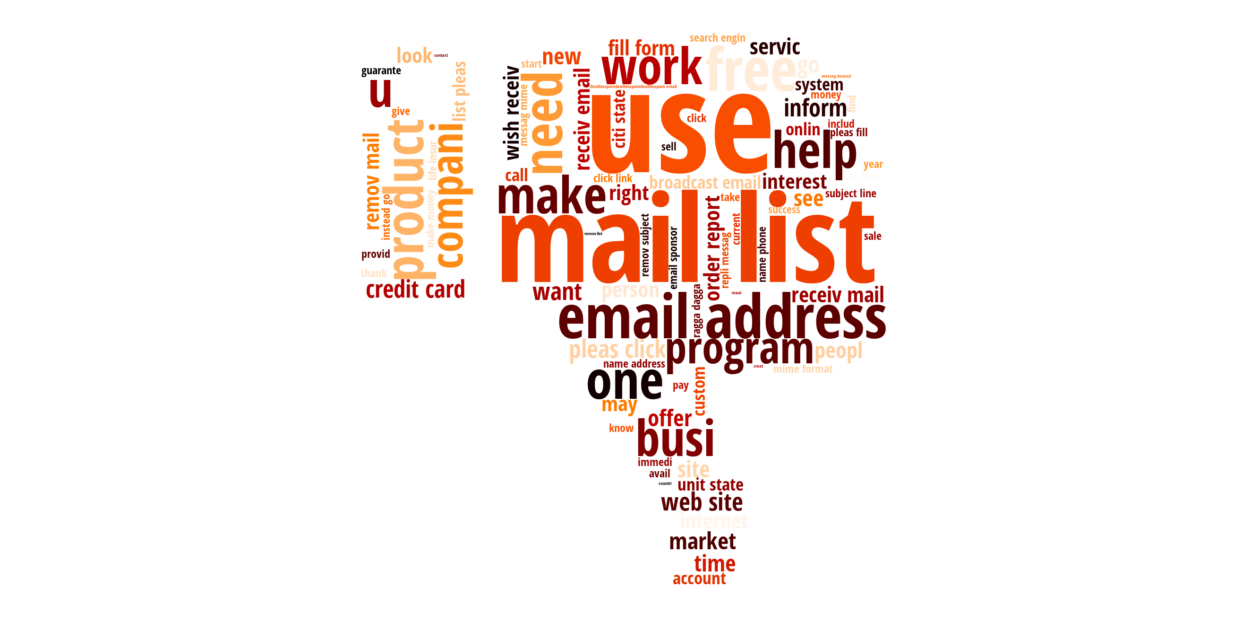

In [67]:
icon=Image.open(Thumbs_down_file)  
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array=np.array(image_mask)# converts image object to array

spam_str=' '.join(flat_list_spam)
word_cloud=WordCloud(mask=rgb_array,background_color='white',
                     max_words=2000,colormap='gist_heat',font_path=Custom_font_file,
                     max_font_size=300)
word_cloud.generate(spam_str)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate Vocabulary and Dictionary

In [68]:
stemmed_nested_list=data.Message.apply(clean_message)
flat_stemmed_list=[item for sublist in stemmed_nested_list for item in sublist]

c:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [69]:
unique_words=pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words',unique_words.shape[0])
unique_words.head()


Nr of unique words 27332


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [70]:
frequent_word=unique_words.iloc[:Vocab_size]
print('Most common word:\n',frequent_word.head(10))

Most common word:
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


## Create Vocabulary Dataframe with Word_Id

In [71]:
word_ids=list(range(0,Vocab_size))
vocab=pd.DataFrame({'Vocab_Word':frequent_word.index.values},index=word_ids)
vocab.index.name='Word_Id'
vocab.head()

,Vocab_Word
Word_Id,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [72]:
vocab.to_csv(Word_Id_FILE,index_label=vocab.index.name,header=vocab.Vocab_Word.name)

### Exercise : Checking if a Word is Part of the Vocabulary

In [73]:
any(vocab.Vocab_Word =='machine')# inefficient

False

In [74]:
word='machin'
word in set(vocab.Vocab_Word) # efficient


True

### Exercise:  Find the Email with the Most Number of Words

In [75]:
maxi=0
j=0
p=0
for i in stemmed_nested_list:

    if maxi<len(i):
        maxi=len(i)
        j= p
    p=p+1
print("len of longest email : ",maxi)
print("At index : ",j)

len of longest email :  7671
At index :  3275


In [76]:
# By List Comprehension
clean_email_lengths=[len(sublist) for sublist in stemmed_nested_list]
print('No of Word in Longest Email : ',max(clean_email_lengths)) 
print('Email position in the list (and the dataframe ) : ',np.argmax(clean_email_lengths))

No of Word in Longest Email :  7671
Email position in the list (and the dataframe ) :  3275


In [77]:
# stemmed_nested_list[np.argmax(clean_email_lengths)]
# print(data.at[np.argmax(clean_email_lengths),'Message'])

## Generate Features & a Sparse Matrix
### Creating a Dataframe with one word per Columns

Sparse Matrix is a full matrix with removal of non occuring element


In [78]:
type(stemmed_nested_list.tolist())
 

list

In [79]:
word_columns_df=pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,greet,receiv,letter,express,interest,receiv,inform,onlin,busi,opportun,...,None,None,None,None,None,None,None,None,None,None
1,need,safeti,real,might,get,one,chanc,readi,free,ship,...,None,None,None,None,None,None,None,None,None,None
2,bonu,fat,absorb,seen,tv,includ,free,purchas,bottl,valu,...,None,None,None,None,None,None,None,None,None,None
3,bonu,fat,absorb,seen,tv,includ,free,purchas,bottl,valu,...,None,None,None,None,None,None,None,None,None,None
4,govern,grant,edit,summer,sale,good,august,receiv,money,need,...,None,None,None,None,None,None,None,None,None,None


In [80]:
word_columns_df.shape

(5796, 7671)

### Spliting the data into a training and testing dataset

In [81]:
X_train,X_test,y_train,y_test=train_test_split(word_columns_df,data.Category,test_size=0.3,random_state=42)

In [82]:
print('no of training sample : ',X_train.shape[0])

no of training sample :  4057


In [83]:
X_train.index.name=X_test.index.name='Doc_Id'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
Doc_Id,,,,,,,,,,,,,,,,,,,,,
4844,bonjour,writ,python,script,order,use,razor,qmail,script,finish,...,None,None,None,None,None,None,None,None,None,None
4727,craig,said,seem,like,good,idea,might,get,one,two,...,None,None,None,None,None,None,None,None,None,None
5022,tim,peter,wrote,still,got,summari,file,pleas,cv,tri,...,None,None,None,None,None,None,None,None,None,None
3504,tue,aug,vincent,cunniff,mention,absolut,way,use,convent,drive,...,None,None,None,None,None,None,None,None,None,None
3921,wed,sep,tom,wrote,other,mail,list,statu,group,run,...,None,None,None,None,None,None,None,None,None,None


In [84]:
y_train.head()

Doc_Id
4844    0
4727    0
5022    0
3504    0
3921    0
Name: Category, dtype: int64

### Create a Sparse Matrix for the Training Data

In [85]:
word_index=pd.Index(vocab.Vocab_Word)
type(word_index)
word_index    

Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'murjel', 'telecommun', 'capitalist', 'magnitud', 'invalid', 'boom',
       'su', 'fake', 'presenc', 'congratul'],
      dtype='object', name='Vocab_Word', length=2500)

In [86]:
word_index.get_loc('thu')

392

In [87]:
def make_sparse_matrix(df,indexed_words,labels):
    """
    Return sparse matrix as dataframe

    df: A Dataframe with words in the columns with a doc id as index {X_train or X_test}
    Indexed_words : index of word ordered by word id
    labels : A category as series (y_train or y_test)
    """
    nr_rows=df.shape[0]
    nr_cols=df.shape[1]
    word_set=set(indexed_words)
    dict_list=[]

    for i in range(nr_rows):
        for j in range(nr_cols):
            word=df.iat[i,j]
            if word in word_set:
                doc_id=df.index[i]
                word_id=indexed_words.get_loc(word)
                category=labels.at[doc_id]

                item={'Label':category,"Doc_Id":doc_id,"Occurence":1,"Word_Id":word_id}
                dict_list.append(item)
        
    return pd.DataFrame(dict_list)


In [88]:
sparse_train_df=make_sparse_matrix(X_train,word_index,y_train)

In [89]:
sparse_train_df.shape

(456343, 4)

In [90]:
sparse_train_df.head()

,Label,Doc_Id,Occurence,Word_Id
0,0,4844,1,1536
1,0,4844,1,637
2,0,4844,1,25
3,0,4844,1,1
4,0,4844,1,456


### Combine  Occurences with the Pandas groupby() Method

In [91]:
train_grouped =sparse_train_df.groupby(['Doc_Id','Word_Id','Label']).sum()


In [92]:
vocab.at[1,"Vocab_Word"]

'use'

In [93]:
# print(data.Message[1])

In [94]:
train_grouped.reset_index(inplace=True)
train_grouped.head()

,Doc_Id,Word_Id,Label,Occurence
0,0,0,1,1
1,0,1,1,4
2,0,2,1,4
3,0,3,1,6
4,0,4,1,1


In [95]:
train_grouped.tail()

,Doc_Id,Word_Id,Label,Occurence
266544,5795,2029,0,1
266545,5795,2210,0,1
266546,5795,2369,0,1
266547,5795,2408,0,3
266548,5795,2458,0,1


In [96]:
vocab.at[2408,'Vocab_Word']

'prob'

In [97]:
data.Message[5795]
# checking above word existed in email and how many times.

"\n\nHi,\n\n\n\nI think you need to give us a little more detailed information.\n\n\n\nOn Wed, 04 Dec 2002, Gianni Ponzi wrote:\n\n\n\n> I have a prob when trying to install Linux (tried RedHat, Suse) on my\n\n> laptop. \n\n\n\nYou get _exactly_ the same problem with Suse and RedHat, is that right?\n\nWhat versions of these have you used?\n\n\n\n> I can start the install but after about 2min, the whole pc just\n\n> dies.\n\n\n\nAs in freezes, reboots?  Do you get any errors?\n\n\n\n> I know it's not a Linux prob and here is what I have encountered:\n\n> \n\n> I had the same problem when installing Win on it and eventually sorted it\n\n> out by disabling the infrared port. \n\n\n\nDid you disable it in the BIOS or in windows?\n\n\n\n> I'm guessing this might be same prob although I'm not sure. I am very new\n\n> to Linux so it's not that easy for me to work it out. I did manage to\n\n> follow the setup procedure at one stage (using images on disks) and it\n\n> cuts out either as it's tr

In [98]:
train_grouped.shape

(266549, 4)

### Save Training Data as .txt File

In [99]:
np.savetxt(Training_Data_File,train_grouped,fmt='%d')

### Create a Sparse Matrix for the Test Data

In [100]:
sparse_test_df=make_sparse_matrix(X_test,word_index,y_test)
sparse_test_df.shape

(176245, 4)

In [101]:
test_grouped=sparse_test_df.groupby(['Doc_Id',"Word_Id","Label"]).sum()

In [102]:
test_grouped.reset_index(inplace=True)

In [103]:
test_grouped.head()

,Doc_Id,Word_Id,Label,Occurence
0,8,0,1,2
1,8,1,1,1
2,8,2,1,1
3,8,3,1,2
4,8,5,1,1


In [104]:
test_grouped.shape

(109582, 4)

### Save Test Data as .txt File


In [105]:
np.savetxt(Test_Data_File,test_grouped,fmt="%d")

Challenge: We have 5796 emails . we split into 4057 emails for training and 1739 for testing .
How many individual emails were included in testing .txt file? Count the number in the test_group dataframe. After splitting and shuffling our data, how many emails are included in X_test Dataframe? is no same?if not which emails are excluded and why?

In [106]:
train_doc_id=set(train_grouped['Doc_Id'])
test_doc_id=set(test_grouped.Doc_Id)

In [107]:
print("len train after grouping :",len(train_doc_id))
len(test_doc_id)

len train after grouping : 4017


1720

In [108]:
print("len train before grouping :",len(X_train))
len(X_test)


len train before grouping : 4057


1739

In [109]:
set(X_test.index.values)-test_doc_id

{45,
 378,
 429,
 439,
 445,
 465,
 670,
 734,
 748,
 1044,
 1186,
 1200,
 1487,
 1593,
 1670,
 1694,
 1765,
 1835,
 1867}

In [110]:
data.Message[45]

'\n\n<HTML>\n\n<BODY>\n\n<!-- saved from url=3D(0022)http://internet.e-mail -->\n\n<head>\n\n<SCRIPT language=3DJavaScript1.2>\n\nif (window.Event) // Only Netscape will have the CAPITAL E.\n\n  document.captureEvents(Event.MOUSEUP); // catch the mouse up event\n\nfunction nocontextmenu()  // this function only applies to IE4, ignored ot=\n\nherwise.\n\n{\n\n\tevent.cancelBubble =3D true;\n\n\tevent.returnValue =3D false;\n\n\n\n\treturn false;\n\n}\n\nfunction norightclick(e)\t// This function is used by all others\n\n{\n\n\tif (window.Event)\t// again, IE or NAV?\n\n\t{\n\n\t\tif (e.which =3D=3D 2 || e.which =3D=3D 3)\n\n\t\t\treturn false;\n\n\t}\n\n\telse\n\n\t\tif (event.button =3D=3D 2 || event.button =3D=3D 3)\n\n\t\t{\n\n\t\t\tevent.cancelBubble =3D true\n\n\t\t\tevent.returnValue =3D false;\n\n\t\t\treturn false;\n\n\t\t}\n\n\t\n\n}\n\n\n\ndocument.oncontextmenu =3D nocontextmenu;\t\t// for IE5+\n\ndocument.onmousedown =3D norightclick;\t\t// for all others\n\n</SCRIPT>\n\n\n\

In [111]:
clean_message(data.at[378,'Message'])

['icagicagicagicagicagicagicagicanciagicagicagicagidxkaxygywxp']

In [112]:
clean_message(data.at[45,'Message'])

[]